In [1]:
import warnings
warnings.filterwarnings('ignore')

# Setting Up Lambda Function for Drought Monitor
This sets up 3 Lambda functions
* Function for public-facing website
* Updator for adding new SMAP data daily to the zarr-staged SMAP data
* Private lambda function for computing the drought categories

In [2]:
import podpac
from podpac.managers import aws
from podpac import settings
# set logging to DEBUG to see build process
import logging
logger = logging.getLogger("podpac")
logger.setLevel(logging.DEBUG)

# Create the Lambda function for the public-facing website
This function restricts the types of pipelines that can be evaluated on the Lambda function. It prevent nefarious use of the general API.

Choose the function and bucket names

In [3]:
settings["FUNCTION_NAME"] = "podpac-drought-monitor-lambda-world"
settings["S3_BUCKET_NAME"] = "podpac-drought-monitor-s3"
settings["FUNCTION_ROLE_NAME"] = "podpac-drought-monitor-role"

Load the pipelines

In [4]:
d0 = podpac.Node.from_json(open('pipeline_d0.json').read())
d1 = podpac.Node.from_json(open('pipeline_d1.json').read())
d2 = podpac.Node.from_json(open('pipeline_d2.json').read())
d3 = podpac.Node.from_json(open('pipeline_d3.json').read())
d4 = podpac.Node.from_json(open('pipeline_d4.json').read())
cats_space = podpac.Node.from_json(open('pipeline_category_space.json').read())
cats_space_us = podpac.Node.from_json(open('pipeline_category_space_us.json').read())
cats_time = podpac.Node.from_json(open('pipeline_category_time.json').read())
smap = podpac.Node.from_json(open('pipeline_moisture_space.json').read())
smap_e_am = podpac.Node.from_json(open('pipeline_moisture_time.json').read())
sin_coords_node = podpac.algorithm.SinCoords()
smap.hash

'490e28901d56acdbaf564f4d44eab053'

Find hashes for functions to restrict capabilities on public Lambda function

In [5]:
hashs = [d0.hash, d1.hash, d2.hash, d3.hash, d4.hash, cats_space.hash, cats_space_us.hash, cats_time.hash, smap.hash, smap_e_am.hash, sin_coords_node.hash]
hashs

['afc29dbb3eb14e470b275b31e1d55d9e',
 'ca56801321f90b37dcc368392a89275d',
 '774021654e983dd54f86594fb731d158',
 '49aaaf6dfe3c913916f1cefd6b51dfe3',
 'b12cc45ddee2dc77138ebfdb27f40568',
 '4e736d8c40ab8deb7cee6d363366bfea',
 '06f1c2d43d2ba251ddcf5fdde3c055d3',
 'd4499c75da6af7f078cf0eab24656472',
 '490e28901d56acdbaf564f4d44eab053',
 'e3a5bcbdc5f06dc7d9ea6759661e1678',
 'b36809eaf1f5af1a7e4286639cfb90a1']

In [5]:
hashs = [d0.hash, d1.hash, d2.hash, d3.hash, d4.hash, cats_space.hash, cats_space_us.hash, cats_time.hash, smap.hash, smap_e_am.hash, sin_coords_node.hash]
hashs

['afc29dbb3eb14e470b275b31e1d55d9e',
 'ca56801321f90b37dcc368392a89275d',
 '774021654e983dd54f86594fb731d158',
 '49aaaf6dfe3c913916f1cefd6b51dfe3',
 'b12cc45ddee2dc77138ebfdb27f40568',
 '4e736d8c40ab8deb7cee6d363366bfea',
 '06f1c2d43d2ba251ddcf5fdde3c055d3',
 'd4499c75da6af7f078cf0eab24656472',
 '490e28901d56acdbaf564f4d44eab053',
 'e3a5bcbdc5f06dc7d9ea6759661e1678',
 'b36809eaf1f5af1a7e4286639cfb90a1']

Make the Lambda function

In [6]:
# make lambda node that is restricted only to this node
node = aws.Lambda(function_restrict_pipelines=hashs, 
                  function_allow_unsafe_eval=True, 
                  function_tags={'owner': 'mpu',
                                 'acct': '1010115.01.003'}, 
                 function_source_bucket=settings["S3_BUCKET_NAME"],
                  # The podpac_dist.zip file is expected to live in the same S3 bucket as specified above. It can be omitted in most cases. 
                  # In this case, it contains a 'settings.json' file that contains some permissions that we did not want to send with API requests.
                 function_source_dist_key='podpac-dm-public.zip',  
                 function_triggers=['eval', 'APIGateway'],
                 function_env_variables={"S3_BUCKET_NAME": settings["S3_BUCKET_NAME"],
                                         "PODPAC_VERSION": podpac.version.semver()
                                        }                  
                 )
node.describe()


Lambda Node (staged)
    Function
        Name: podpac-drought-monitor-lambda-world
        Description: PODPAC Lambda Function (https://podpac.org)
        ARN: None
        Triggers: ['eval', 'APIGateway']
        Handler: handler.handler
        Environment Variables: {'S3_BUCKET_NAME': 'podpac-drought-monitor-s3', 'PODPAC_VERSION': '2.0.0'}
        Timeout: 600 seconds
        Memory: 2048 MB
        Tags: {'owner': 'mpu', 'acct': '1010115.01.003'}
        Source Dist: s3://podpac-drought-monitor-s3/podpac-dm-public.zip
        Source Dependencies: s3://podpac-drought-monitor-s3/dev/podpac_deps.zip
        Last Modified: None
        Version: None
        Restrict Evaluation: ['afc29dbb3eb14e470b275b31e1d55d9e', 'ca56801321f90b37dcc368392a89275d', '774021654e983dd54f86594fb731d158', '49aaaf6dfe3c913916f1cefd6b51dfe3', 'b12cc45ddee2dc77138ebfdb27f40568', '2715fbe59be4642a38a6b9399cde1fe5', 'ab7a63174ee39eda324630c69b902688', '30cf38e0d17d2662dd2c80b741ae5aa4', '5172b237bb5964b2b76a

In [9]:
node.delete_function()
node.delete_api()
node.build()
node.describe()

DEBUG:podpac.core.managers.aws:Getting lambda function podpac-drought-monitor-lambda-world
DEBUG:podpac.core.managers.aws:Failed to get lambda function podpac-drought-monitor-lambda-world with exception: An error occurred (ResourceNotFoundException) when calling the GetFunction operation: Function not found: arn:aws:lambda:us-east-1:120507435541:function:podpac-drought-monitor-lambda-world
DEBUG:podpac.core.managers.aws:Getting lambda function podpac-drought-monitor-lambda-world
DEBUG:podpac.core.managers.aws:Failed to get lambda function podpac-drought-monitor-lambda-world with exception: An error occurred (ResourceNotFoundException) when calling the GetFunction operation: Function not found: arn:aws:lambda:us-east-1:120507435541:function:podpac-drought-monitor-lambda-world
DEBUG:podpac.core.managers.aws:Lambda function 'podpac-drought-monitor-lambda-world' does not exist
DEBUG:podpac.core.managers.aws:Getting API Gateway with name podpac-drought-monitor-lambda-world-api
DEBUG:podpac.

To finalize budget creation, you must visit https://console.aws.amazon.com/billing/home#/preferences/tags and 'Activate' the following User Defined Cost Allocation tags: ['_podpac_resource_hash'].
Budget tracking will not work if these User Defined Cost Allocation tags are not active.
Budget creation and usage updates may take 24 hours to take effect.


DEBUG:podpac.core.managers.aws:Successfully created budget 'podpac-drought-monitor-lambda-world-budget'
DEBUG:podpac.core.managers.aws:Getting IAM role with name podpac-drought-monitor-role
DEBUG:podpac.core.managers.aws:Getting lambda function podpac-drought-monitor-lambda-world
DEBUG:podpac.core.managers.aws:Getting API Gateway with name podpac-drought-monitor-lambda-world-api
DEBUG:podpac.core.managers.aws:Getting S3 bucket podpac-drought-monitor-s3
DEBUG:podpac.core.managers.aws:Getting budget with name podpac-drought-monitor-lambda-world-budget
INFO:podpac.core.managers.aws:Successfully built AWS resources to support function podpac-drought-monitor-lambda-world



Lambda Node (built)
    Function
        Name: podpac-drought-monitor-lambda-world
        Description: PODPAC Lambda Function (https://podpac.org)
        ARN: arn:aws:lambda:us-east-1:120507435541:function:podpac-drought-monitor-lambda-world
        Triggers: ['eval', 'APIGateway']
        Handler: handler.handler
        Environment Variables: {'PODPAC_UNSAFE_EVAL': 'b754a7523c574ec0b88c9c831a4e5ffb', 'PODPAC_VERSION': '2.0.0', 'S3_BUCKET_NAME': 'podpac-drought-monitor-s3', 'PODPAC_RESTRICT_PIPELINES': '["afc29dbb3eb14e470b275b31e1d55d9e", "ca56801321f90b37dcc368392a89275d", "774021654e983dd54f86594fb731d158", "49aaaf6dfe3c913916f1cefd6b51dfe3", "b12cc45ddee2dc77138ebfdb27f40568", "2715fbe59be4642a38a6b9399cde1fe5", "ab7a63174ee39eda324630c69b902688", "30cf38e0d17d2662dd2c80b741ae5aa4", "5172b237bb5964b2b76a0b43fc5b887a", "acbc745131566a990a999dbd1fdc8021", "b36809eaf1f5af1a7e4286639cfb90a1"]'}
        Timeout: 600 seconds
        Memory: 2048 MB
        Tags: {'_podpac_resource': 

Now we test the Lambda function to make sure it works.

DEBUG:podpac.core.data.datasource:Evaluating Zarr data source
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:podpac.core.data.datasource:Evaluating Zarr data source


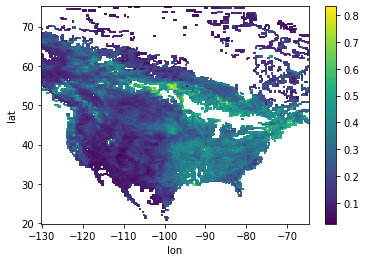

In [9]:
o = smap.eval(coordinates)
o.plot()

DEBUG:podpac.core.managers.aws:Evaluating pipeline via invoke synchronously
DEBUG:podpac.core.managers.aws:Received response from lambda function


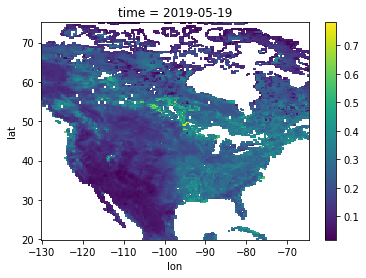

In [8]:
coordinates = podpac.Coordinates([podpac.clinspace(20, 75, 180), podpac.clinspace(-130,-65, 180), '2019-05-19'], ['lat', 'lon', 'time'])

# this will work
node = aws.Lambda(source=d0, eval_settings=settings)
output = node.eval(coordinates)
output.plot()
pass

# Lambda function to update SMAP data zarr store
This uses a slightly-modified `podpac_dist.zip` file. Its `handler.py` was modified according to the [UpdateSMAPData Notebook](UpdateSMAPData.ipynb)

In [5]:
settings["FUNCTION_NAME"] = "podpac-drought-monitor-lambda-smap-world-updater"
settings["S3_BUCKET_NAME"] = "podpac-drought-monitor-s3"
settings["FUNCTION_ROLE_NAME"] = "podpac-drought-monitor-role"

Load the pipelines

Make the Lambda function

In [6]:
# make lambda node that is restricted only to this node
updater_node = aws.Lambda(function_tags={'owner': 'mpu',
                                 'acct': '1010115.01.003'}, 
                 function_source_bucket=settings["S3_BUCKET_NAME"],
                 function_source_dist_key='podpac-dm-smap-world-updater.zip',
                 function_env_variables={"S3_BUCKET_NAME": settings["S3_BUCKET_NAME"],
                                         "PODPAC_VERSION": podpac.version.semver()
                                        }                  
                 )
updater_node.describe()


Lambda Node (staged)
    Function
        Name: podpac-drought-monitor-lambda-smap-world-updater
        Description: PODPAC Lambda Function (https://podpac.org)
        ARN: None
        Triggers: ['eval']
        Handler: handler.handler
        Environment Variables: {'S3_BUCKET_NAME': 'podpac-drought-monitor-s3', 'PODPAC_VERSION': '1.3.1'}
        Timeout: 600 seconds
        Memory: 2048 MB
        Tags: {'owner': 'mpu', 'acct': '1010115.01.003'}
        Source Dist: s3://podpac-drought-monitor-s3/podpac-dm-smap-world-updater.zip
        Source Dependencies: s3://podpac-drought-monitor-s3/dev/podpac_deps.zip
        Last Modified: None
        Version: None
        Restrict Evaluation: []

    S3
        Bucket: podpac-drought-monitor-s3
        Tags: {'owner': 'mpu', 'acct': '1010115.01.003'}
        Input Folder: input/
        Output Folder: output/

    Role
        Name: podpac-drought-monitor-role
        Description: PODPAC Lambda Role
        ARN: None
        Policy Docu

In [7]:
# updater_node.delete_function()
updater_node.build()

DEBUG:podpac.core.managers.aws:Getting IAM role with name podpac-drought-monitor-role
DEBUG:podpac.core.managers.aws:Getting lambda function podpac-drought-monitor-lambda-smap-world-updater
DEBUG:podpac.core.managers.aws:Failed to get lambda function podpac-drought-monitor-lambda-smap-world-updater with exception: An error occurred (ResourceNotFoundException) when calling the GetFunction operation: Function not found: arn:aws:lambda:us-east-1:120507435541:function:podpac-drought-monitor-lambda-smap-world-updater
DEBUG:podpac.core.managers.aws:Skipping API get because 'APIGateway' not in the function triggers
DEBUG:podpac.core.managers.aws:Getting S3 bucket podpac-drought-monitor-s3
DEBUG:podpac.core.managers.aws:Getting budget with name podpac-drought-monitor-lambda-smap-world-updater-budget
ERROR:podpac.core.managers.aws:Failed to get budget with name podpac-drought-monitor-lambda-smap-world-updater-budget with exception: An error occurred (NotFoundException) when calling the Describe

To finalize budget creation, you must visit https://console.aws.amazon.com/billing/home#/preferences/tags and 'Activate' the following User Defined Cost Allocation tags: ['_podpac_resource_hash'].
Budget tracking will not work if these User Defined Cost Allocation tags are not active.
Budget creation and usage updates may take 24 hours to take effect.


DEBUG:podpac.core.managers.aws:Successfully created budget 'podpac-drought-monitor-lambda-smap-world-updater-budget'
DEBUG:podpac.core.managers.aws:Getting IAM role with name podpac-drought-monitor-role
DEBUG:podpac.core.managers.aws:Getting lambda function podpac-drought-monitor-lambda-smap-world-updater
DEBUG:podpac.core.managers.aws:Skipping API get because 'APIGateway' not in the function triggers
DEBUG:podpac.core.managers.aws:Getting S3 bucket podpac-drought-monitor-s3
DEBUG:podpac.core.managers.aws:Getting budget with name podpac-drought-monitor-lambda-smap-world-updater-budget
DEBUG:podpac.core.managers.aws:Skipping API validation because 'APIGateway' not in the function triggers
INFO:podpac.core.managers.aws:Successfully built AWS resources to support function podpac-drought-monitor-lambda-smap-world-updater


# Lambda function to compute drought categories
This is very similar to the first Lambda function -- but this has no evaluation restrictions.

In [7]:
settings["FUNCTION_NAME"] = "podpac-drought-monitor-lambda-compute-stats"
settings["S3_BUCKET_NAME"] = "podpac-drought-monitor-s3"
settings["FUNCTION_ROLE_NAME"] = "podpac-drought-monitor-role"

Load the pipelines

Make the Lambda function

In [8]:
# make lambda node that is restricted only to this node
compute_node = aws.Lambda(
    function_allow_unsafe_eval=True,
    function_tags={'owner': 'mpu', 'acct': '1010115.01.003'}, 
    function_source_bucket=settings["S3_BUCKET_NAME"],
    function_source_dist_key='podpac_dist_stats.zip',
    function_source_dependencies_key='podpac_deps.zip',
    function_env_variables={
        "S3_BUCKET_NAME": settings["S3_BUCKET_NAME"],
        "PODPAC_VERSION": podpac.version.semver()
    }
)
compute_node.describe()


Lambda Node (staged)
    Function
        Name: podpac-drought-monitor-lambda-compute-stats
        Description: PODPAC Lambda Function (https://podpac.org)
        ARN: None
        Triggers: ['eval']
        Handler: handler.handler
        Environment Variables: {'S3_BUCKET_NAME': 'podpac-drought-monitor-s3', 'PODPAC_VERSION': '1.3.1'}
        Timeout: 600 seconds
        Memory: 2048 MB
        Tags: {'owner': 'mpu', 'acct': '1010115.01.003'}
        Source Dist: s3://podpac-drought-monitor-s3/podpac_dist_stats.zip
        Source Dependencies: s3://podpac-drought-monitor-s3/podpac_deps.zip
        Last Modified: None
        Version: None
        Restrict Evaluation: []

    S3
        Bucket: podpac-drought-monitor-s3
        Tags: {'owner': 'mpu', 'acct': '1010115.01.003'}
        Input Folder: input/
        Output Folder: output/

    Role
        Name: podpac-drought-monitor-role
        Description: PODPAC Lambda Role
        ARN: None
        Policy Document: {'Version': '2

In [9]:
compute_node.delete_function()
compute_node.build()

DEBUG:podpac.core.managers.aws:Getting lambda function podpac-drought-monitor-lambda-compute-stats
DEBUG:podpac.core.managers.aws:Failed to get lambda function podpac-drought-monitor-lambda-compute-stats with exception: An error occurred (ResourceNotFoundException) when calling the GetFunction operation: Function not found: arn:aws:lambda:us-east-1:120507435541:function:podpac-drought-monitor-lambda-compute-stats
DEBUG:podpac.core.managers.aws:Getting lambda function podpac-drought-monitor-lambda-compute-stats
DEBUG:podpac.core.managers.aws:Failed to get lambda function podpac-drought-monitor-lambda-compute-stats with exception: An error occurred (ResourceNotFoundException) when calling the GetFunction operation: Function not found: arn:aws:lambda:us-east-1:120507435541:function:podpac-drought-monitor-lambda-compute-stats
DEBUG:podpac.core.managers.aws:Lambda function 'podpac-drought-monitor-lambda-compute-stats' does not exist
DEBUG:podpac.core.managers.aws:Getting IAM role with name 